# Data Preprocessing 

This notebook performs the initial Data Preprocessing on a small sample of the LJSpeech Dataset (286 audio samples from 2 speakers). Following this, the MFCC and Text Transcripts extracted will be passed on to the SV2TTS model.

In [15]:
import os
from pathlib import Path
import sys
import hparams as hp
import pandas as pd
import librosa as lr
import librosa.display as ld
import glob
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [119]:
############## Hyperparameters (to be moved to hparams.py)  #######################

### Directory Locations ###
data_dir = "./data/LJSpeech/"
save_dir_mfcc = "./data/LJSpeech/mfcc/"
save_dir_transcripts = "./data/LJSpeech/transcripts/"

### FFT Parameters ###
n_fft = 2048
hop_length = 512
n_mfcc = 13
mel_len = 290                      # frame length of mel spectrogram > Spectrogram is split into short-time frames
n_fft = 1024 
n_mels = 80                        # number of mel filters (number of Mel bands to generate)
hop_length = 256                   # audio samples between adjacent STFT columns
win_length = 1024                  # window length
mel_fmin = 0.0                     # minimum mel bank
mel_fmax = 8000                    # maximum mel bank
r = 3                              # number of frames generated on each timestep


In [4]:
## Reading the audio metadata into a pandas dataframe
df = pd.read_csv(hp.data_dir+'metadata.csv', sep='|')
df.head()

,ID,Text,Normalized_Text
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...


In [55]:
## Extracting the Audio IDs for future use
audioIds = df.ID.tolist()

In [5]:
## Loading a sample audio 
wav_dir = hp.data_dir +'wavs/*.wav'
files = glob.glob(wav_dir)
files[0], len(files)

('./data/LJSpeech/wavs\\LJ001-0001.wav', 286)

In [7]:
ipd.Audio(files[98])

In [44]:
wavs = []
durations = []

for f in files:
    audio, sr = lr.load(f,sr=22050)  #audio is a numpy array [sr*duration(t) = 22.5k * t]
    audio, _ = lr.effects.trim(audio)  # triming
    wavs.append(audio)
    durations.append(lr.get_duration(y=audio, sr=sr))   

865

In [89]:
## Determining the maximum width of spectrograms for padding
max_padding = np.ceil(max(durations)*sr/hop_length).astype(int)
max_padding

865

## Displaying the amplitude envelope

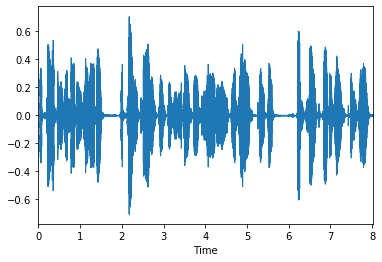

In [9]:
sample = wavs[98]
ld.waveplot(sample, sr=sr)
plt.show()

In [10]:
durations[98]

8.029614512471655

# Power Spectrum

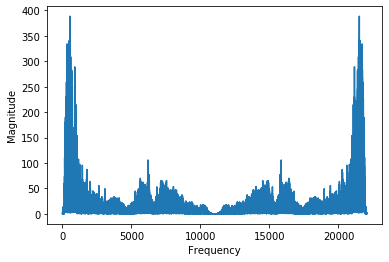

In [11]:

fft = np.fft.fft(sample)  # Num of values: sr * duration
magnitude = np.abs(fft)
frequency = np.linspace(0,sr, len(magnitude))
plt.plot(frequency, magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

In [35]:
def plot_mfcc(mfcc):
    ld.specshow(mfcc,sr=sr, hop_length= hop_length)
    plt.xlabel("Time")
    plt.ylabel("MFCC")
    plt.colorbar()
    plt.show()

# STFT

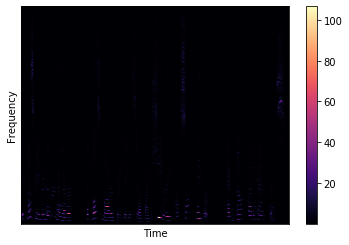

In [12]:
'''
n_fft : window that we consider when performing a single FT
hop_length: amount of interval we shift each FT to the right

'''
n_fft = 2048
hop_length = 512
'''
Size of stft = 
dim1 = n_fft/2 + 1
dim2 = ceil(sr*t/hop_length) + 1

'''
stft = lr.core.stft(sample, hop_length = hop_length, n_fft=n_fft)
spectrogram = np.abs(stft)

ld.specshow(spectrogram,sr=sr, hop_length= hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

## Mel-Spectrogram

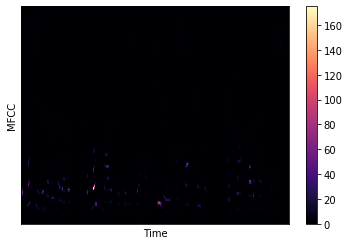

In [78]:
## Mel Spectrogram
melspec = lr.feature.melspectrogram(sample, hop_length = hop_length, n_fft=n_fft)
plot_mfcc(melspec)

## MFCC

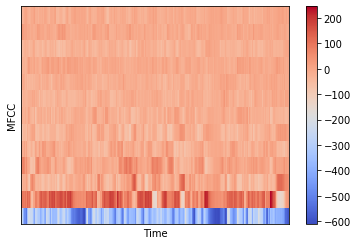

In [68]:
mfcc = lr.feature.mfcc(sample, hop_length = hop_length, n_fft=n_fft, n_mfcc=13) #n_mfcc: number of coefficients we want to extract
plot_mfcc(mfcc)

## Mean- normalized MFCC

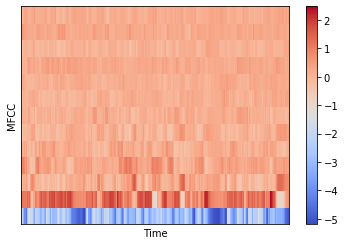

In [69]:
mean = np.mean(np.ndarray.flatten(mfcc))
std = np.std(np.ndarray.flatten(mfcc))
mfcc = (mfcc - mean) / std
plot_mfcc(mfcc)

## Padded MFCC

0 173


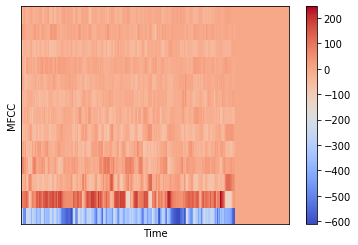

In [47]:
## Padded MFCC
mfcc = lr.feature.mfcc(sample, hop_length = hop_length, n_fft=n_fft, n_mfcc=13) #n_mfcc: number of coefficients we want to extract
shape = (n_mfcc, max_padding)
mfcc = _padding(mfcc, shape)
plot_mfcc(mfcc)

## Sinusoidal Liftering (TODO: verify advantages over vanilla MFCC)

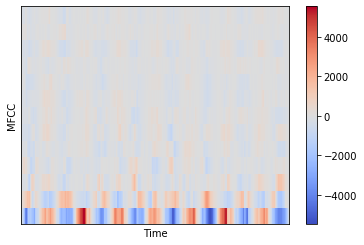

In [31]:
## Sinusoidal Liftering

'''
Some implementations of MFCC apply sinusoidal liftering as the final step in calculations of MFCC. 
It is claimed that speech recognition can be significantly improved. 

https://dsp.stackexchange.com/questions/26019/sinusoidal-liftering-in-implementations-of-mfcc
'''
(nframes, ncoeff) = mfcc.shape
n = np.arange(ncoeff)
cep_lifter = 23 
lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
mfcc *= lift
ld.specshow(mfcc,sr=sr, hop_length= hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

In [103]:
def _padding(x, shape, value=0):
    r"""Add padding to have a desired shape.
    Args:
        x (numpy.ndarray): Input array.
        shape (tuple of int): The desired shape.
        value (int, optional): Value to be padded. Defaults to 0.
    Returns:
        numpy.ndarray: An output array with a desired shape.
    """
    row_padding = shape[0] - x.shape[0]
    col_padding = shape[1] - x.shape[1]
    
    return np.pad(x, [[0, row_padding], [0, col_padding]], mode="constant", constant_values=value)

In [70]:
def _normalize(mfcc):
    x = np.ndarray.flatten(mfcc)
    mean = np.mean(x)
    std = np.std(x)
    mfcc = (mfcc - mean) / std
    return mfcc

## Generate and Save the MFCCs as .npy files for future use

In [104]:
'''
MFCC output dimensions:
(n_mfcc=13, [Audio Length * SampleRate / Hop Length])
'''
mfccs = []

def save_mfcc(wavs, max_padding):
    
    if not os.path.exists(save_dir_mfcc):
        os.mkdir(save_dir_mfcc)
        print("Directory created successfully!")
        
    shape = (n_mfcc, max_padding)
    
    for i in tqdm(range(len(audioIds))):
        
        mfcc = lr.feature.mfcc(wavs[i], hop_length = hop_length, n_fft=n_fft, n_mfcc=13) 
        mfccs.append(mfcc)
        mfcc = _normalize(mfcc) # mean normalization
        mfcc = _padding(mfcc, shape) # Zero padding 
        assert mfcc.shape == shape  #Sanity check
        
        np.save(save_dir_mfcc + audioIds[i]+'.npy',mfcc)  


In [105]:
save_mfcc(wavs, max_padding)

100%|████████████████████████████████████████████████████████████████████████████████| 286/286 [00:12<00:00, 22.38it/s]


## Loading a random MFCC (Sanity check)

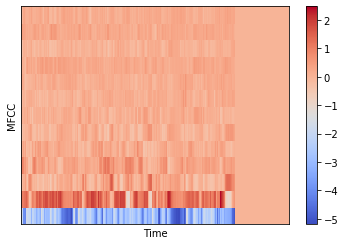

In [153]:
sample = audioIds[98]
mfcc = np.load(save_dir_mfcc+sample+'.npy')
plot_mfcc(mfcc)

## Pre-process Text transcripts

Steps:
- A Vocabulary created from all characters in the audio transcripts
- Normalize the transcripts
- Perform a padding with a max_length
- Generate indexes from characters and vice-versa
- Encode the text
- Save as .npy files

In [133]:
transcripts = df.Normalized_Text.tolist()
## Create a vocabulary from all unique characters in the transcripts
vocab = list({ch for text in transcripts for ch in text}) 
vocab.append('~')  # Add the padding character
vocab = sorted(vocab)  # Sort alphabetically
#Character to Index mapping
char2idx = {ch: i for i, ch in enumerate(vocab)}
#Index to Character mapping
idx2char = {i: ch for i, ch in enumerate(vocab)}

In [140]:
def _preprocess_transcripts(df, char2idx):
    
    if not os.path.exists(save_dir_transcripts):
        os.mkdir(save_dir_transcripts)
        print("Directory created successfully!")
        
    transcripts = df.Normalized_Text.tolist()
    max_len = len(max(transcripts, key=len))
   
    
    for i in tqdm(range(len(audioIds))):

        text = transcripts[i]
        # TODO: Text normalization  > neu.tts.text.text_normalize
        text = text.ljust(max_len, '~')   ## Padding the text to a max length
        text = [char2idx[ch] for ch in text]  ## convert text to a numeric encoding
        np.save(save_dir_transcripts + audioIds[i]+'.npy',text)
    

In [141]:
_preprocess_transcripts(df, char2idx)

100%|██████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 1232.88it/s]


## Loading a random transcript (Sanity check)

In [156]:
sample = audioIds[98]
file = np.load(save_dir_transcripts+sample+'.npy')
print("Encoded text: \n", file)
s = [idx2char[idx] for idx in file]
print("\nOriginal Text: \n"+ "".join(s))

Encoded text: 
 [18 52  0 45 53 51 52  0 34 37  0 50 37 45 37 45 34 37 50 37 36  5  0 40
 47 55 37 54 37 50  5  0 52 40 33 52  0 45 47 51 52  0 45 47 36 37 50 46
  0 48 50 41 46 52 41 46 39  0 41 51  0 36 47 46 37  0 34 57  0 45 33 35
 40 41 46 37 50 57  0 47 46  0 51 47 38 52  0 48 33 48 37 50  5  0 33 46
 36  0 46 47 52  0 34 57  0 52 40 37  0 40 33 46 36  0 48 50 37 51 51  5
 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59
 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59 59]

Original Text: 
It must be remembered, however, that most modern printing is done by machinery on soft paper, and not by the hand press,~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
